In [ ]:
import gc
gc.collect()

35

# Library

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm  #==0.9.2
!pip install transformer
!pip install einops

from __future__ import print_function
from __future__ import division

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as T

import os
import pandas as pd
import numpy as np

import json
import csv
import cv2 # for image load
from copy import deepcopy

from PIL import Image

import albumentations as A
import albumentations.pytorch
import torchvision.transforms as transforms
from torch.utils.data import random_split

import timm

import random
import plotly.express as px # for grap
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from tqdm import tqdm # for progress bar

!pip install transformers
from PIL import Image
from torchvision.transforms import ToTensor
from transformers import ViTFeatureExtractor, ViTModel
import torch

import glob
from multiprocessing import cpu_count, Pool
from einops import repeat

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement transformer (from versions: none)
ERROR: No matching distribution found for transformer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# avail_pretrained_models = timm.list_models(pretrained=True)
# len(avail_pretrained_models), avail_pretrained_models

# Get Dataset

In [ ]:
# 3d 폴더 안에 코드와 데이터 zip 파일 함께 있어야 합니다
# DIR = '/content/drive/MyDrive/3d/'
DIR = '/content/drive/MyDrive/ML/DATA302/dataset' # 혜진

FAKE_IMG_DIR = '/content/data/fake/'
REAL_IMG_DIR = '/content/data/real/'

In [ ]:
# !mkdir data
os.system(f"unzip {DIR}/LSUN-bedroom-set.zip -d /content/data")

0

# WanDB

In [ ]:
# !pip install wandb
# import wandb
# !wandb login
# # 4f01143bff7345de8651eb7dfcaf29dccacf6ba9

# Env

In [ ]:
model_list = timm.list_models(pretrained=True)

In [ ]:
idx = np.random.randint(len(model_list))
model_list[idx]

'resnet50d.ra2_in1k'

In [ ]:
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

random.seed(42)

model_list = {
    "vit_base_patch16_224.augreg_in21k" : { # timm
        "model" : "vit_base_patch16_224.augreg_in21k",
        "input_size" : (224, 224),
        "classifier_in_feature" : 768
        },
     'vit_relpos_base_patch16_clsgap_224.sw_in1k' : { # timm (안씀)
        "model" :  'vit_relpos_base_patch16_clsgap_224.sw_in1k',
        "input_size" : (224, 224),
        "classifier_in_feature" : 768
        },
      'vit_medium_patch16_gap_256.sw_in12k_ft_in1k' : { # timm (안씀)
        "model" :  'vit_medium_patch16_gap_256.sw_in12k_ft_in1k',
        "input_size" : (256, 256),
        "classifier_in_feature" : 512
        },
        'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k' : {
        "model" :  'eva02_base_patch14_448.mim_in22k_ft_in22k_in1k',
        "input_size" : (448, 448),
        "classifier_in_feature" : 768
        },
        'resnext50_32x4d.a1_in1k' : {
        "model" :  'resnext50_32x4d.a1_in1k',
        "input_size" : (224, 224),
        "classifier_in_feature" : 2048
        },
}

optimizer_list = ["adam", "sgd"]

# vit = 'vit_base_patch16_224.augreg_in21k'
# vit_input_size = (224, 224)
# vit_classifier_in_feature = 768
# (H, W, C) = 16,16,3
# out_feature_size = (H, W, C)

model_name = 'resnext50_32x4d.a1_in1k'

CONFIG = {
    "batch_size" : 8,
    "epoch" : 200,
    "learning_rate" : 1e-4,
    "input_size" : model_list[model_name]["input_size"],
    "backbone" : model_list[model_name]["model"],
    "classifier_in_feature": model_list[model_name]["classifier_in_feature"],
    "device" : device,
    "patience" : 10,
    "optimizer" : optimizer_list[0],
    "input_norm_mean" : IMAGENET_DEFAULT_MEAN,
    "input_norm_std" : IMAGENET_DEFAULT_STD
}



batch_size = CONFIG["batch_size"]
epochs = CONFIG["epoch"]
learning_rate = CONFIG["learning_rate"]
input_size = CONFIG["input_size"]
backbone = CONFIG["backbone"]
classifier_in_feature = CONFIG["classifier_in_feature"]
device = CONFIG["device"]
patience = CONFIG["patience"]
optimizer = CONFIG["optimizer"]
input_norm_mean = CONFIG["input_norm_mean"]
input_norm_std = CONFIG["input_norm_std"]

Using cpu device


# Read the Data

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, FAKE_path, REAL_path, input_size, transform=None, isTest=False):

        self.FAKE_path = FAKE_path
        self.REAL_path = REAL_path
        self.input_size = input_size
        self.transform = transform
        self.isTest = isTest
        self.img_list = []

        for i in range(len(FAKE_path)):
            img_path = FAKE_path[i]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image=np.array(image))['image']
            self.img_list.append((image, 0))

        for i in range(len(REAL_path)):
            img_path = REAL_path[i]
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image=np.array(image))['image']
            self.img_list.append((image, 1))

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        image, label = self.img_list[idx]

        return image, label #label type: int

In [ ]:
# Get Fake Data
FAKE_paths = glob.glob(FAKE_IMG_DIR + "*")

# Get Real Data
REAL_paths = glob.glob(REAL_IMG_DIR + "*")

train_transform = A.Compose([
    A.PadIfNeeded(*input_size),
    A.RandomCrop(*input_size),
    albumentations.augmentations.transforms.Normalize(
        mean=input_norm_mean,
        std=input_norm_std
        ),
    albumentations.pytorch.transforms.ToTensorV2()
])

test_transform = A.Compose([
    A.PadIfNeeded(*input_size),
    albumentations.augmentations.crops.transforms.CenterCrop(*input_size),
    albumentations.augmentations.transforms.Normalize(
        mean=input_norm_mean,
        std=input_norm_std
        ),
    albumentations.pytorch.transforms.ToTensorV2()
])

labeled_dataset = CustomDataset(FAKE_paths[:-500], REAL_paths[:-501], input_size=input_size, transform=train_transform, isTest=False)
#train_dataloader = DataLoader(
#    dataset=train_dataset,
#    batch_size=batch_size,
#    shuffle=True
#)


test_dataset = CustomDataset(FAKE_paths[-500:], REAL_paths[-500:], input_size=input_size, transform=test_transform, isTest=True)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# real, fake 개수 각 2951개
print(len(labeled_dataset))
print(len(test_dataset))

def dataset_split(dataset, ratio):
    train_size = int(ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    return train_dataset, val_dataset

1950
1000


In [ ]:
print(len(FAKE_paths))
print(len(REAL_paths))

1418
1533


# Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.best_score = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}.")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# PRNU

In [ ]:
#DIR2 = '/content/drive/MyDrive/2023학교/기컴비'
#os.system(f"unzip {DIR2}/prnu-model.zip -d /content/")

In [ ]:
# !git clone https://github.com/polimi-ispl/prnu-python # 혜진
# os.system(f"unzip /content/drive/MyDrive/ML/DATA302/prnu-model.zip") # 혜진
!git clone https://github.com/polimi-ispl/prnu-python # 은빈, 지영
os.system(f"unzip /content/drive/MyDrive/3d/prnu-model.zip -d /content/data") # 은빈, 지영

Cloning into 'prnu-python'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 160 (delta 0), reused 0 (delta 0), pack-reused 157
Receiving objects: 100% (160/160), 125.65 MiB | 24.89 MiB/s, done.
Resolving deltas: 100% (36/36), done.


2304

In [ ]:
%cd prnu-python
!pwd

/content/prnu-python
/content/prnu-python


In [ ]:
import prnu
# import model_zoo

In [ ]:
def PRNU(x): # batch_size * 224 * 224 * 3
    prnu_len = (x.shape)[0]
    # print("this is prnu_len!", prnu_len)
    prnu_noise = []
    for i in range(prnu_len):
      im = x[i].cpu().numpy()
      im = np.transpose(im,(2,1,0))
      im = np.asarray(im, np.uint8)
      im = im.astype(np.uint8)
      #im = (x[i]).numpy()
    #   print("this is im's shape!", im.shape)
      if im.dtype != np.uint8:
        print('Error while reading image')
      if im.ndim != 3:
        print('Image is not RGB')

    #   print("size before prnu!",im.shape)
      im_cut0 = prnu.cut_ctr(im, (*input_size, 3))
      #img = prnu.extract_multiple_aligned([im_cut0], processes=cpu_count())
      img = prnu.extract_single(im_cut0)
      prnu_noise += [torch.from_numpy(img).unsqueeze(0)]

    prnu_noise = np.stack(prnu_noise,0)
    # print("final shape!",prnu_noise.shape)
    return prnu_noise

In [ ]:
prnu1 = PRNU
# prnu1 = None

# FFT

In [ ]:
def FFT(x, mode):# x == prnu_noise
    ims = deepcopy(x[:, 0:3, 0:224,0:224]) # im shape: [B, 3, 224, 224]
    ims = x.astype(np.float32)
    ims = ims/255.0
    for i in range(ims.shape[0]):
        img = ims[i, :, :, :]
        fft_img = np.fft.fftn(img)
        fft_img = np.fft.ifftshift(fft_img)
        fft_img = np.log(np.abs(np.fft.fftshift(fft_img))+1e-3)
        fft_min = np.percentile(fft_img,5) # fft_img에서 하위 5%의 값
        fft_max = np.percentile(fft_img,95) # fft_img에서 하위 95%의 값 (상위 5%)
        fft_img = (fft_img - fft_min)/(fft_max - fft_min + 1e-5)
        fft_img = (fft_img-0.5)*2
        fft_img[fft_img<-1] = -1
        fft_img[fft_img>1] = 1
        #set mid and high freq to 0
        if mode>0:
            fft_img = np.fft.fftshift(fft_img)
            if mode == 1:
                fft_img[:57, :] = 0
                fft_img[:, :57] = 0
                fft_img[177:, :] = 0
                fft_img[:, 177:] = 0
            #set low and high freq to 0
            elif mode == 2:
                fft_img[:21, :] = 0
                fft_img[:, :21] = 0
                fft_img[203:, :] = 0
                fft_img[:, 203:] = 0
                fft_img[57:177, 57:177] = 0
            #set low and mid freq to 0
            elif mode == 3:
                fft_img[21:203, 21:203] = 0
            fft_img = np.fft.fftshift(fft_img)
        ims[i, :, :, :] = fft_img
        # ims = np.transpose(ims,(3,1,2,0))
        #ims = torch.from_numpy(im).float()
    return ims # batch_size * 224 * 224 * 3

In [ ]:
fft = FFT

# Deprecated

In [ ]:
class pescado(nn.Module): # FFT + ViT
    def __init__(self, backbone, classifier_in_feature, prnu, fft, device, pretrained=True):
        super().__init__()
        # self.prnu = prnu
        self.fft = fft
        self.device = device
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone.reset_classifier(0)
        # self.backbone_classifier = nn.Linear(
        #         in_features=classifier_in_feature,
        #         out_features=196
        #     )

        # for param in self.backbone.parameters():
        #     param.requires_grad=False

        self.classifier = nn.Sequential(
            nn.Linear(classifier_in_feature, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        # output = self.backbone(x) # B 1 1000
        # v_out = self.backbone_classifier(output)

        fft_map = self.fft(x.detach().cpu().numpy(), 0) # fft_map (8, 3, 224, 224)
        output = self.backbone(torch.from_numpy(fft_map).to(device))
        v_out = self.classifier(output)

        return v_out

In [ ]:
class melon(nn.Module): # PRNU+FFT+ViT -> 다시 EVA로 바꿈
    def __init__(self, backbone, classifier_in_feature, prnu, fft, device, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.backbone.reset_classifier(0)
        self.prnu = prnu
        self.fft = fft
        self.device = device

        self.classifier = nn.Sequential(
            nn.Linear(classifier_in_feature, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        prnu_img = self.prnu(x) # prnu_img (8, 1, 224, 224)
        fft_map = self.fft(prnu_img, 0) # fft_map (8, 1, 224, 224)
        fft_map = torch.from_numpy(fft_map).to(self.device) # torch.Size([8, 1, 224, 224])
        v_in = repeat(fft_map, 'b c h w -> b (c x) h w', x=3)
        vit_feature = self.backbone(v_in) # torch.Size([8, 768])
        out = self.classifier(vit_feature)

        return out

# Model

In [ ]:
class strawberry(nn.Module):
    def __init__(self, backbone, classifier_in_feature, prnu, fft, device, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone, pretrained=False)
        self.backbone.reset_classifier(0)
        self.backbone_classifier = nn.Linear(
                in_features=classifier_in_feature,
                out_features=196
            )
        self.prnu = prnu
        self.fft = fft
        self.device = device

        # for param in self.backbone.parameters():
        #     param.requires_grad=False

        self.potato = nn.Linear(196, 196)
        self.maxpool = nn.MaxPool2d(16, stride=16)

        self.classifier = nn.Sequential(
            nn.Linear(classifier_in_feature, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        output = self.backbone(x) # B 1 1000
        v_out = self.backbone_classifier(output)

        prnu_img = self.prnu(x) # prnu_img (8, 1, 224, 224)
        fft_map = self.fft(prnu_img, 0) # fft_map (8, 1, 224, 224)
        fft_map = torch.from_numpy(fft_map).to(self.device)
        fft_feature = self.maxpool(fft_map) # fft_feature torch.Size([8, 1, 14, 14])
        fft_feature = nn.Flatten()(fft_feature).to(self.device) # fft_feature torch.Size([8, 196])
        fft_out = self.potato(fft_feature).to(self.device) # fft_out size: [B, 196]

        x1 = torch.cat((v_out, fft_out), dim=1) # x1 size: [B, 196+196]

        x1 = self.classifier(x1)

        return x1

In [ ]:
model = melon(backbone, classifier_in_feature, prnu1, fft, device)
model.to(device)
print(model)

melon(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256,

# PRNU 평균 구하기

In [ ]:
# train_dataset, val_dataset = dataset_split(labeled_dataset, 0.8) # 8 : 2 = train : val
train_dataloader = DataLoader(
    dataset=labeled_dataset,
    batch_size=1,
    shuffle=True
)

In [ ]:
real_result = []
fake_result = []

for batch, (x, gt) in enumerate(tqdm(train_dataloader, desc="train")):

    prnu_img = prnu1(x) # prnu_img (8, 1, 224, 224)
    fft_map = fft(prnu_img, 0) # fft_map (8, 1, 224, 224)

    if gt[0] == 1:
      real_result.append(fft_map[0])
    elif gt[0] == 0:
      fake_result.append(fft_map[0])

avg_real_result = np.mean(real_result, axis=0)
avg_fake_result = np.mean(fake_result, axis=0)

train: 100%|██████████| 1950/1950 [03:09<00:00, 10.28it/s]


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
avg_real_result[0] - avg_fake_result[0]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.03984672, -0.04231161, ..., -0.0494231 ,
        -0.040856  , -0.03516525],
       [ 0.        , -0.02438575, -0.04549456, ..., -0.04352337,
        -0.02050948, -0.03005958],
       ...,
       [ 0.        , -0.04377747, -0.03673053, ..., -0.05022192,
        -0.04496527, -0.01697779],
       [ 0.        , -0.03005958, -0.02050948, ..., -0.01564771,
        -0.04549456, -0.02438575],
       [ 0.        , -0.03516525, -0.040856  , ..., -0.05470783,
        -0.04231161, -0.03984672]], dtype=float32)

In [ ]:
avg_real_result[0]

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -0.7798891 , -0.7796846 , ..., -0.71418136,
        -0.7745471 , -0.7868321 ],
       [-1.        , -0.7677678 , -0.7961147 , ..., -0.73081714,
        -0.77768   , -0.78426623],
       ...,
       [-1.        , -0.71635205, -0.7351428 , ..., -0.6972811 ,
        -0.7288531 , -0.6854229 ],
       [-1.        , -0.78426623, -0.77768   , ..., -0.72662914,
        -0.7961147 , -0.7677678 ],
       [-1.        , -0.7868321 , -0.7745471 , ..., -0.7019982 ,
        -0.7796846 , -0.7798891 ]], dtype=float32)

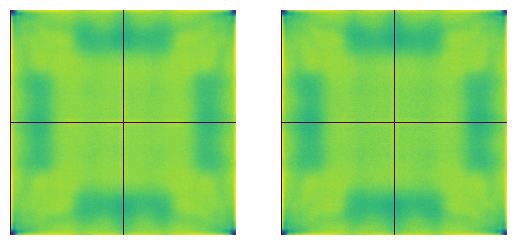

In [ ]:
plt.subplot(121)
plt.imshow(avg_real_result[0])
plt.axis("off")
plt.subplot(122)
plt.imshow(avg_fake_result[0])
plt.axis("off")
plt.show()

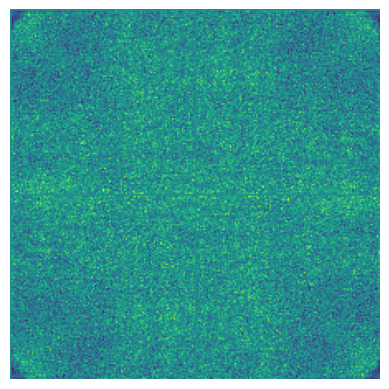

In [ ]:
plt.imshow((avg_real_result[0] - avg_fake_result[0])/2)
plt.axis("off")
plt.show()

In [ ]:
# import matplotlib.pyplot as plt

# for batch, (x, gt) in enumerate(train_dataloader):
#     output = fft(x.cpu().numpy(), 3)

#     x = (x + 1) / 2
#     output = (output + 1) / 2

#     for i in range(batch_size):

#         if gt[i] == 1:
#             print("real image")
#         else:
#             print("fake image")

#         plt.subplot(121)
#         plt.imshow(np.transpose(x[i], (1,2,0)))
#         plt.axis("off")
#         plt.subplot(122)
#         plt.imshow(np.transpose(output[i], (1,2,0)))
#         plt.axis("off")
#         plt.show()
#         print("=======================================================")
#     break

# Training and Validation Function

In [ ]:
def train_model(device, model, optimizer, loss_fn, dataloader):
    model.train()
    correct = 0
    running_loss = 0
    pred_ans, gt_ans = [], []

    for batch, (x, gt) in enumerate(tqdm(dataloader, desc="train")):
        x, gt = x.to(device), gt.to(device)
        # print(f"아아아아아: ", x.size())
        output = model(x)
        loss = loss_fn(output, gt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss

        pred = output.argmax(dim=1)
        pred_ans += pred.tolist()
        gt_ans += gt.tolist()
        correct += torch.sum(pred == gt.data)

    acc = 100 * correct / (len(dataloader) * batch_size)
    running_loss = running_loss/len(dataloader)

    return running_loss, acc, pred_ans, gt_ans

@torch.no_grad()
def valid_model(device, model, dataloader):
    model.eval()
    loss = 0
    running_loss = 0
    correct = 0
    pred_ans, gt_ans = [], []

    for batch, (x, gt) in enumerate(tqdm(dataloader, desc="validation")):
        x, gt = x.to(device), gt.to(device)
        output = model(x)
        loss = loss_fn(output, gt).item()

        pred = output.argmax(dim=1)

        running_loss += loss
        pred_ans += pred.tolist()
        gt_ans += gt.tolist()
        correct += torch.sum(pred == gt.data)

    acc = 100 * correct / (len(dataloader) * batch_size)
    running_loss = running_loss/len(dataloader)

    return running_loss, acc, pred_ans, gt_ans


# Training

In [ ]:
# run = wandb.init(
#             project="3d",
#             config=CONFIG
#             ) # start a new run

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_dataset, val_dataset = dataset_split(labeled_dataset, 0.8) # 8 : 2 = train : val
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
# MODEL_PATH = '/content/drive/MyDrive/3d/'
MODEL_PATH = '/content/drive/MyDrive/ML/DATA302/checkpoints/vit+fft'  # 혜진
val_loss_list = []
train_loss_list = []
cur_loss_min = np.inf


for e in range(epochs):
    print(f"\nEpoch {e+1}")
    train_loss, train_acc, train_pred, train_gt = train_model(device, model, optimizer, loss_fn, train_dataloader)
    val_loss, val_acc, val_pred, val_gt = valid_model(device, model, val_dataloader)

    # wandb.log({"train loss": train_loss,
    #            "train accuracy": train_acc,
    #            "validation loss": val_loss,
    #            "validation accuracy": val_acc})

    print(f"train loss: {train_loss}\tvalidation loss: {val_loss}")

    if val_loss < cur_loss_min:
        print(f"Validation loss reduced ({cur_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        cur_loss_min = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_PATH, f'checkpoints_epoch{e+1}'))

    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

from google.colab import files
files.download(f"{MODEL_PATH}")


In [ ]:
# wandb.save(MODEL_PATH)

# artifact = wandb.Artifact('model', type='model')
# artifact.add_file(MODEL_PATH)
# run.log_artifact(artifact)

# wandb.finish()

# Test

In [ ]:
@torch.no_grad()
def test_model(device, model, dataloader):
    pred_ans = []
    gt_ans = []
    corrects = 0

    model.eval()
    model = model.to(device)

    for x, gt in tqdm(dataloader):  # tqdm: progress bar 표시
        x, gt = x.to(device), gt.to(device)
        output = model(x)

        pred = output.argmax(dim=1)

        pred_ans += pred.tolist()
        gt_ans += gt.tolist()
        corrects += torch.sum(pred == gt.data)

    # accuracy 출력
    print(f"total accuracy: {corrects / len(dataloader.dataset)}")

    return pred_ans, gt_ans


In [ ]:
# confusion matrix 시각화
import matplotlib.pyplot as plt
import itertools    # confusion matrix에서 사용
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(label, pred, target_names=None, labels=True):
    cm = confusion_matrix(label, pred)
    accuracy = np.trace(cm) / float(np.sum(cm))

    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    thresh = cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/3d/checkpoints_epoch4"))
model.eval()

pescado(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
 

100%|██████████| 125/125 [01:25<00:00,  1.45it/s]


total accuracy: 0.796000063419342


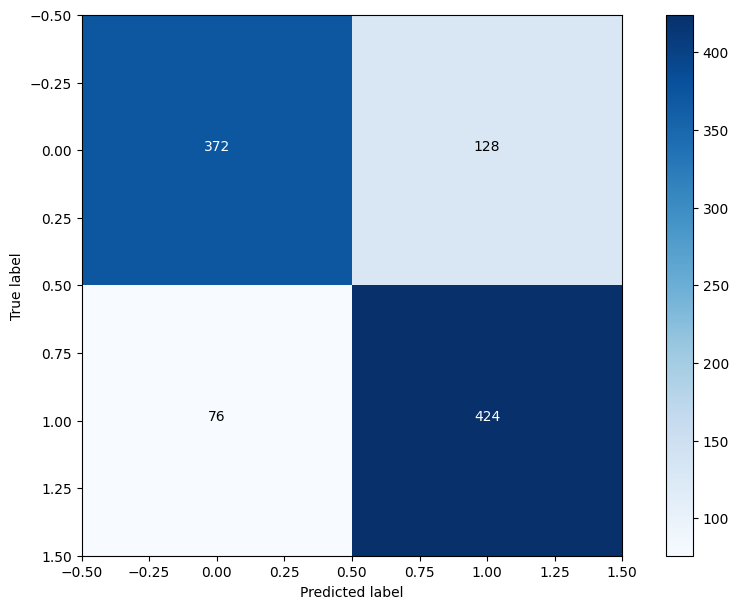

In [ ]:
pred_ans, gt_ans = test_model(device, model, test_dataloader)
plot_confusion_matrix(gt_ans, pred_ans)

## 기록 저장

In [ ]:
MODEL_PATH = "checkpoint.pt"
val_loss_list = []
train_loss_list = []
cur_loss_min = np.inf


for e in range(epochs):
    print(f"\nEpoch {e+1}")
    train_loss, train_acc, train_pred, train_gt = train_model(device, model, optimizer, loss_fn, train_dataloader)
    val_loss, val_acc, val_pred, val_gt = valid_model(device, model, val_dataloader)

    # wandb.log({"train loss": train_loss,
    #            "train accuracy": train_acc,
    #            "validation loss": val_loss,
    #            "validation accuracy": val_acc})

    print(f"train loss: {train_loss}\tvalidation loss: {val_loss}")

    if val_loss < cur_loss_min:
        print(f"Validation loss reduced ({cur_loss_min:.6f} --> {val_loss:.6f}). Saving model ...")
        cur_loss_min = val_loss
        torch.save(model.state_dict(), MODEL_PATH)

    val_loss_list.append(val_loss)
    train_loss_list.append(train_loss)

from google.colab import files
files.download(f"/content/{MODEL_PATH}")
